Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)
* Taylon L C Martins (RA: 177.379)

# Lista 02

## Tarefa

Abordar o problema de reconhecimento de atividades humanas (HAR, do inglês _human activity recognition_) a partir de informações capturadas por sensores de smartphones.

Utilizar regressão logística e kNN, com os dados pré-processados e dados brutos.

**Dataset**

* [UCI HAR](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)

* Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [85]:
# Import modules

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly.express as px

In [2]:
# Define if will rerun models
RERUN = False

## Common Functions

In [3]:
# Read csv function with options
def read_csv_(path, sep=r"\s+|;|:|,"):
    return pd.read_csv(filepath_or_buffer=path, sep=sep, engine="python", header=None)

In [4]:
# Function to perform a 5-fold Cross-validation
def do_CV(X, y, model, n_splits=5, verbose=False, retrain_all=False):
    skf = StratifiedKFold(n_splits=n_splits)
    recall = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        if verbose:
            print(f"Split {i}: balanced accuracy={balanced_accuracy}")
        recall.append(balanced_accuracy)
    if retrain_all:
        model.fit(X, y)
    return np.mean(recall)

In [5]:
# Function to summarize results
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")


def model_summary(model, X_test, y_test, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Recall", "F1 score")]
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        f1_macro = f1_score(y_test, y_pred, average="macro")
        results.append(
            ("All", f"{balanced_accuracy:0.4f}", f"{f1_macro:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        for label, r, f1 in zip(labels, recall, f1):
            results.append((label, f"{r:0.4f}", f"{f1:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        _, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=0)
        conf_matrix_disp.im_.set_clim(0, 600)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()


    y_pred = model.predict(X_test)
    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

## Preprocessed Dataset

In [6]:
# Get label names
df_labels = read_csv_(r"..\Lista02\UCI_HAR_Dataset\activity_labels.txt")
df_labels.drop(0, axis=1, inplace=True)
df_labels = df_labels.rename(columns={1: "activity"})
labels = [s.title().replace("Walking_","W. ").replace("stairs","s.")
          for s in df_labels["activity"].values]


def get_label_name(i):
    return labels[i - 1]

In [7]:
# Get feature names
df_features = read_csv_(r"..\Lista02\UCI_HAR_Dataset\features.txt", sep=r"\s+")
df_features.drop(0, axis=1, inplace=True)
df_features = df_features.rename(columns={1: "feature"})
features = df_features["feature"].values


def get_feature_name(i):
    return df_features["feature"][i]

In [8]:
# Read preprocessed data
X = read_csv_(r"..\Lista02\UCI_HAR_Dataset\train\X_train.txt")
y = read_csv_(r"..\Lista02\UCI_HAR_Dataset\train\y_train.txt")
X_test = read_csv_(r"..\Lista02\UCI_HAR_Dataset\test\X_test.txt")
y_test = read_csv_(r"..\Lista02\UCI_HAR_Dataset\test\y_test.txt")

print("Train data")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")
print("Test data")
print(f"  X: {X_test.shape}")
print(f"  y: {y_test.shape}")

Train data
  X: (7352, 561)
  y: (7352, 1)
Test data
  X: (2947, 561)
  y: (2947, 1)


In [9]:
# Count labels
train_labels = y[0].unique()
train_labels.sort()
train_label_count = [len(y[0][y[0] == label]) for label in train_labels]

test_labels = y_test[0].unique()
test_labels.sort()
test_label_count = [len(y_test[0][y_test[0] == label]) for label in test_labels]

print(f"Labels are the same: {np.all(test_labels == train_labels)}")
max_labels_ratio = min(train_label_count) / max(train_label_count)
print(f"Smallest/Largest train labels: {max_labels_ratio*100:0.2f}%")

Labels are the same: True
Smallest/Largest train labels: 70.08%


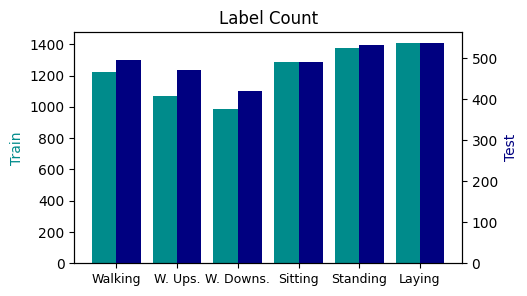

In [10]:
# Build label count plot
fig, ax1 = plt.subplots(figsize=(5, 3))
ax2 = ax1.twinx()

ax1.bar(
    np.arange(len(labels)) - 0.2,
    train_label_count,
    color="darkcyan",
    width=0.4,
    align="center",
)
ax1.set_ylabel("Train", color="darkcyan")

ax2.bar(
    np.arange(len(labels)) + 0.2,
    test_label_count,
    color="navy",
    width=0.4,
    align="center",
)
ax2.set_ylabel("Test", color="navy")

plt.title("Label Count")
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, rotation=0, fontdict={'fontsize':9})

plt.savefig("report/png/A_LabelCount.png", bbox_inches="tight")
plt.show()

Aparentemente o desbalanço entre as classes não é significativo (menor classe tem 30% menos elementos que a maior classe), mas existe. De toda forma será utilizada a acurácia balanceada como métrica da qualidade do classificador (média dos _recalls_ de cada classe).

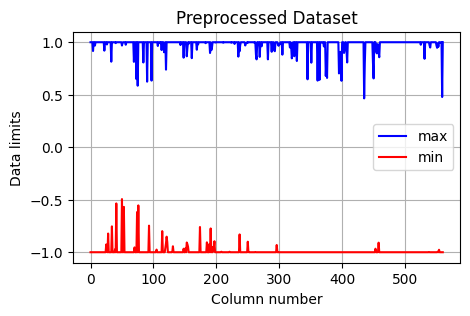

In [11]:
# Check data
plt.figure(figsize=(5, 3))
plt.plot(X.max(), color="blue",label="max")
plt.plot(X.min(), color="red",label="min")

plt.xlabel("Column number")
plt.ylabel("Data limits")
plt.title("Preprocessed Dataset")
plt.grid(True)
plt.legend(loc="center right")
plt.savefig(r"report/png/A_Dataset_Scale", bbox_inches="tight")
plt.show()

Dados estão normalizados em [-1;1], com algumas poucas exceções. Os testes seguirão com os dados originais.

### Logistic Regression

Opções utilizadas:

* Validação cruzada estratificada em 5 pastas.
* Normalização $l_2$ ($\frac{1}{2} ||w||_2^2$), com otimização do seu inverso ($c = \frac{1}{l_2}$)
* Função objetivo da otimização: acurácia balanceada.
* Estratégia: multinomial (entropia cruzada).

Fontes: 

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [12]:
# Build logistic model
if RERUN:
    logistic = LogisticRegressionCV(
        cv=5, solver="saga", scoring="balanced_accuracy", random_state=42, n_jobs=-1
    )
    logistic.fit(X, y[0].values)
    _ = joblib.dump(logistic, "logistic_model.sav")
else:
    logistic = joblib.load("logistic_model.sav")

print(f"Normalization coefficients l2:\n {[np.round(1/c, 4) for c in logistic.C_]}")

balanced_accuracy = {}
balanced_accuracy[("Logistic","CV")] = logistic.score(X, y[0].values)
print(f"Logistic CV balanced accuracy = {balanced_accuracy[('Logistic','CV')]:0.4f}")
y_pred = logistic.predict(X_test)
balanced_accuracy[("logistic","Test")] = recall_score(y_test, y_pred, average="macro")


Normalization coefficients l2:
 [0.3594, 0.3594, 0.3594, 0.3594, 0.3594, 0.3594]
Logistic CV balanced accuracy = 0.9932


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.9598 | 0.9606   |
---------------------------------
| Walking   | 0.9940 | 0.9686   |
| W. Ups.   | 0.9427 | 0.9569   |
| W. Downs. | 0.9690 | 0.9795   |
| Sitting   | 0.8717 | 0.9214   |
| Standing  | 0.9812 | 0.9372   |
| Laying    | 1.0000 | 1.0000   |


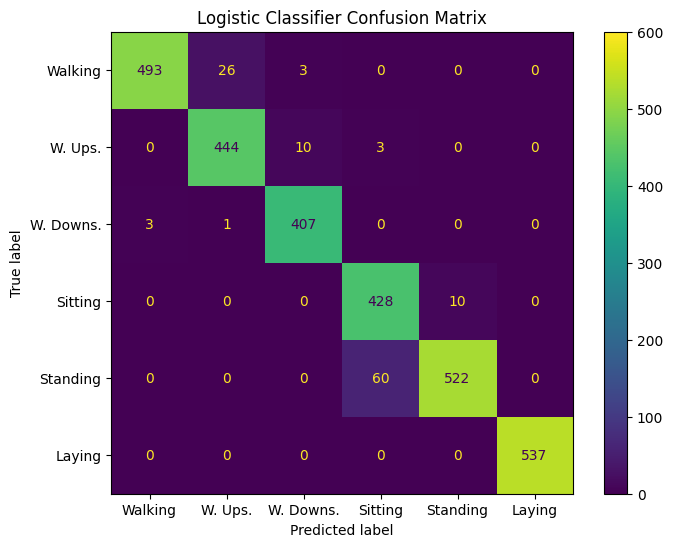

In [13]:
# Summarize logistic model
model_summary(
    model=logistic,
    X_test=X_test,
    y_test=y_test,
    labels=labels,
    description="Logistic Classifier",
    filename="A_Logistic_CM.png",
)

O F1-score também seria uma boa escolha para avaliar a qualidade dos classificadores.

Em geral o classificador tem um bom desempenho. Ao analisar por classe, fica claro que o desempenho não é uniforme. A classe 'SITTING' tem um valor de recall bem mais baixo que as demais.

### kNN

Primeira tentativa de construção de um classificador com kNN utilizou as opções _padrão_ da implementação do Scikit-Learn.

In [14]:
# Function to optimize k in a kNN classifier
def find_knn_best_k(
    X, y, model, k_range, plot_filename=None, verbose=False, details=False
):
    results = []
    for k in k_range:
        model.set_params(n_neighbors=k)
        bal_acc = do_CV(X=X, y=y[0], model=model, verbose=details)
        if verbose:
            print(f"k={k}: balanced_accuracy = {bal_acc:0.4f}")
        results.append(bal_acc)

    best_i = results.index(max(results))
    best_k = k_range[best_i]
    if verbose:
        print(f"Best k={best_k}")
        print(f"Balanced accuracy = {results[best_i]:0.4f}")

    model.set_params(n_neighbors=best_k)
    model.fit(X, y[0])

    if plot_filename is not None:
        plt.figure(figsize=(5, 3))
        plt.plot(k_range, results, color="black", marker="o")
        plt.plot(best_k, results[best_i], color="red", marker="o", label=f"K = {best_k}")

        plt.xlabel("k")
        plt.ylabel("Balanced accuracy")
        plt.title("k-Nearest Neighbours")
        plt.grid(True)
        plt.legend()
        plt.savefig(f"report/png/{plot_filename}", bbox_inches="tight")
        plt.show()

    return model, best_k, results[best_i]

In [15]:
# Build vanilla kNN
print("Vanilla kNN")

if RERUN:
    knn_vanilla = KNeighborsClassifier()
    results = find_knn_best_k(
        X=X,
        y=y,
        model=knn_vanilla,
        k_range=range(1, 30),
        plot_filename="A_kNN_bestK.png",
        verbose=True,
    )
    knn_vanilla, best_k, balanced_accuracy[("kNN vanilla","CV")] = results

    _ = joblib.dump(knn_vanilla, "knn_vanilla_model.sav")
else:
    knn_vanilla = joblib.load("knn_vanilla_model.sav")
    best_k = knn_vanilla.get_params()["n_neighbors"]
    print(f"Best k = {best_k}")
    balanced_accuracy[("kNN vanilla","CV")] = do_CV(
        X=X,
        y=y[0],
        model=knn_vanilla,
        retrain_all=True)
    print(f"Balanced accuracy = {balanced_accuracy[('kNN vanilla','CV')]:0.4f}")

y_pred = knn_vanilla.predict(X_test)
balanced_accuracy[("kNN vanilla","Test")] = recall_score(y_test, y_pred, average="macro")

Vanilla kNN
Best k = 17


Balanced accuracy = 0.8999


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.8999 | 0.9017   |
---------------------------------
| Walking   | 0.9839 | 0.9104   |
| W. Ups.   | 0.9108 | 0.9022   |
| W. Downs. | 0.7667 | 0.8530   |
| Sitting   | 0.7984 | 0.8578   |
| Standing  | 0.9436 | 0.8885   |
| Laying    | 0.9963 | 0.9981   |


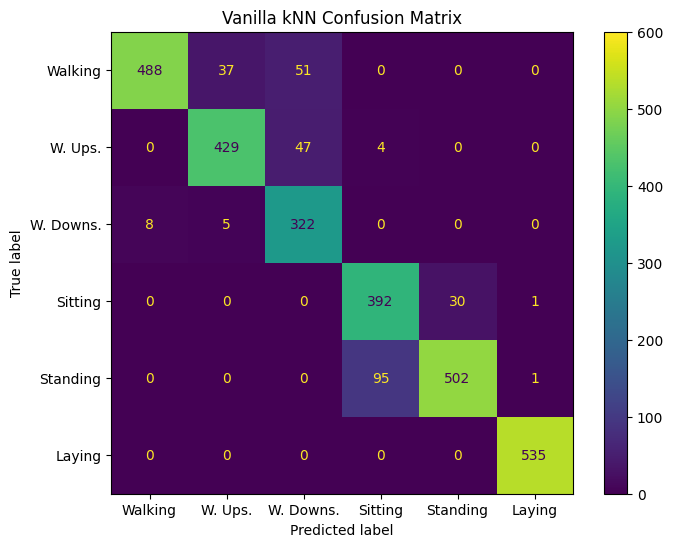

In [16]:
# Vanilla kNN summary
model_summary(
    model=knn_vanilla,
    X_test=X_test,
    y_test=y_test,
    labels=labels,
    description="Vanilla kNN",
    filename="A_kNN_Vanilla_CM",
)

Foi feita uma busca em grade ao redor do melhor k encontrado, buscando os melhores hiperparâmetros para o classificador de k-vizinhos mais próximos. 

In [17]:
# kNN with hyperparameter GridSearch optimization
print("Optimized hyperparameters")
param_grid = {
    "n_neighbors": np.arange(best_k - 1, best_k + 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}
if RERUN:

    knn_opt1 = KNeighborsClassifier()
    grid_search = GridSearchCV(
        estimator=knn_opt1,
        param_grid=param_grid,
        cv=3,
        scoring="balanced_accuracy",
        n_jobs=-1,
    )

    grid_search.fit(X, y[0].values)
    best_params = grid_search.best_params_

    _ = joblib.dump(knn_opt1, "knn_opt1_model.sav")
else:
    knn_opt1 = joblib.load("knn_opt1_model.sav")

best_params = {k:v for k,v in knn_opt1.get_params().items() if k in param_grid}
print(f"Best hyperparameters={best_params}")
balanced_accuracy[("kNN opt1","CV")] = do_CV(X=X, y=y[0], model=knn_opt1, retrain_all=True)
print(f"Balanced accuracy = {balanced_accuracy[('kNN opt1','CV')]:0.4f}")
y_pred = knn_opt1.predict(X_test)
balanced_accuracy[("kNN opt1","Test")] = recall_score(y_test, y_pred, average="macro")

Optimized hyperparameters
Best hyperparameters={'n_neighbors': 17, 'p': 1, 'weights': 'distance'}


Balanced accuracy = 0.9045


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.9146 | 0.9165   |
---------------------------------
| Walking   | 0.9859 | 0.9200   |
| W. Ups.   | 0.9108 | 0.8966   |
| W. Downs. | 0.7786 | 0.8651   |
| Sitting   | 0.8330 | 0.8979   |
| Standing  | 0.9793 | 0.9197   |
| Laying    | 1.0000 | 1.0000   |


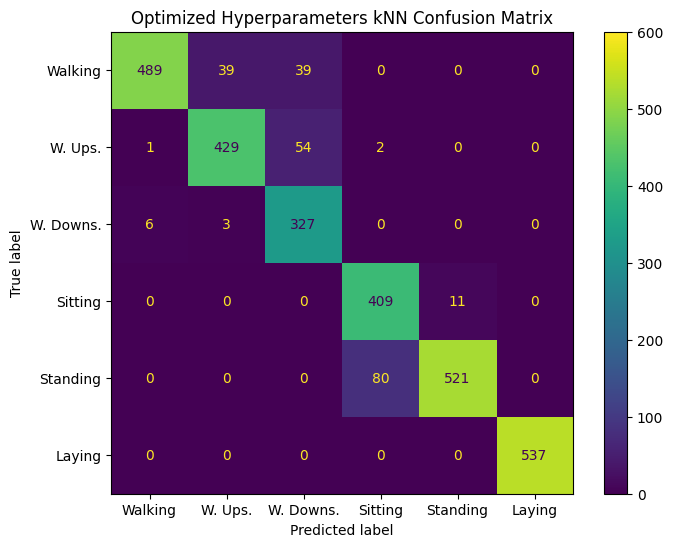

In [18]:
# Optimized kNN summary
model_summary(
    model=knn_opt1,
    X_test=X_test,
    y_test=y_test,
    labels=labels,
    description="Optimized Hyperparameters kNN",
    filename="A_kNN_opt1_CM.png",
)

Resultado do classificador kNN ficou abaixo do logístico. Os valores de acurácia balanceada já indicavam este comportamento. Nesta primeira tentativa apenas o valor de K, p e critério de pesos foram avaliados. Uma nova tentativa será feita aplicando normalização [0,1] a todos os dados.

In [19]:
# Build model with features scaled [0;1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=X.columns)

print("[0;1] Scaled X kNN")

if RERUN:
    knn_scaled = KNeighborsClassifier(**best_params)
    knn_scaled.fit(X_scaled, y[0].values)
    _ = joblib.dump(knn_scaled, "knn_scaled_model.sav")
else:
    knn_scaled = joblib.load("knn_scaled_model.sav")

balanced_accuracy[("kNN scaled","CV")] = do_CV(
    X=X_scaled,
    y=y[0],
    model=knn_scaled,
    retrain_all=True)
print(f"Balanced accuracy = {balanced_accuracy[('kNN scaled','CV')]:0.4f}")
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_pred = knn_scaled.predict(X_test_scaled)
balanced_accuracy[("kNN scaled","Test")] = recall_score(y_test, y_pred, average="macro")

[0;1] Scaled X kNN


Balanced accuracy = 0.9059


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.9153 | 0.9173   |
---------------------------------
| Walking   | 0.9859 | 0.9209   |
| W. Ups.   | 0.9151 | 0.8989   |
| W. Downs. | 0.7786 | 0.8662   |
| Sitting   | 0.8350 | 0.8981   |
| Standing  | 0.9793 | 0.9205   |
| Laying    | 0.9981 | 0.9991   |


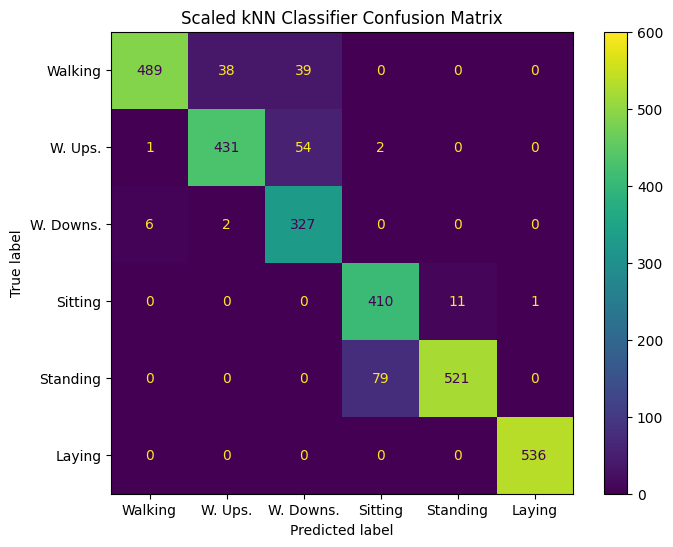

In [20]:
# Scaled kNN summary
model_summary(
    model = knn_scaled,
    X_test = X_test_scaled,
    y_test=y_test,
    labels=labels,
    description="Scaled kNN Classifier",
    filename="A_kNN_Scaled_CM.png"
)

Aplicar uma escala [0;1] nos dados de entrada levou a uma pequena melhora na acuária balanceada.

A última etapa na busca por um classificador kNN de melhores resultados é testando os parâmetros de entrada. É feita uma otimização _gulosa_ dos parâmetros que devem ser utilizados na construção do classificador de k-vizinhos mais próximos. 

A cada iteração são avaliados todos os parâmetros de entrada. É feito um teste retirando um dos parâmetros de entrada. O modelo kNN é reconstruído e se a acurácia balanceada aumentar, este parâmetro é retirado permamentemente. O algoritmo para quando nenhum parâmetro for retirado em uma iteração. 

In [21]:
# Functions to filter and optimize columns used
def filtered_df(df, boolean_list):
    columns_to_select = {column: value for column, value in zip(df.keys(), boolean_list) if value}
    return pd.DataFrame(df)[columns_to_select.keys()]

def trim_columns_model(X, y, model, n_splits=2, max_iterations=10, shuffle=True):
    changes = 99
    iterations = 0
    columns = list(range(len(X.columns)))
    keep = [True] * len(X.columns)
    best_ba = do_CV(X=X, y=y[0], model=model, n_splits=n_splits)
    print(f"Iteration 0: Columns = {keep.count(True)}, Balanced Accuracy = {best_ba:0.4f}")
    while changes > 0 and iterations < max_iterations:
        iterations += 1
        changes = 0
        if shuffle:
            random.shuffle(columns)
        for i in columns:
            if keep[i]:
                keep_try = keep.copy()
                keep_try[i] = False
                X_new = filtered_df(X, keep_try)
                new_ba = do_CV(X=X_new, y=y[0], model=model, n_splits=n_splits)
                if new_ba >= best_ba:
                    best_ba = new_ba
                    keep = keep_try
                    changes += 1
        print(f"Iteration {i}: Columns = {keep.count(True)}, Balanced Accuracy = {best_ba:0.4f}")
    return keep

In [22]:
# Build trimmed kNN
print("kNN Trimmed")
knn_opt2 = KNeighborsClassifier(**best_params)
if RERUN:
    columns_keep = trim_columns_model(
        model=knn_opt2,
        X=X_scaled,
        y=y,
        max_iterations=1,
        n_splits=5)
    _ = joblib.dump(columns_keep, "knn_trim_columns.sav")
else:
    columns_keep = joblib.load("knn_trim_columns.sav")

n_kept = columns_keep.count(True)
n_kept_pc = n_kept / len(columns_keep)
print(f"Columns kept = {n_kept} ({n_kept_pc*100:0.2f}%)")
X_trim = filtered_df(X_scaled, columns_keep)
balanced_accuracy[("kNN trimmed","CV")] = do_CV(
    X=X_trim,
    y=y[0],
    model=knn_opt2,
    retrain_all=True)
print(f"Balanced accuracy = {balanced_accuracy[('kNN trimmed','CV')]:0.4f}")
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_pred = knn_opt2.predict(filtered_df(X_test_scaled, columns_keep))
balanced_accuracy[("kNN trimmed","Test")] = recall_score(y_test, y_pred, average="macro")

kNN Trimmed
Columns kept = 496 (88.41%)


Balanced accuracy = 0.9218


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.9192 | 0.9211   |
---------------------------------
| Walking   | 0.9839 | 0.9251   |
| W. Ups.   | 0.9214 | 0.9032   |
| W. Downs. | 0.7881 | 0.8711   |
| Sitting   | 0.8350 | 0.9031   |
| Standing  | 0.9868 | 0.9243   |
| Laying    | 1.0000 | 1.0000   |


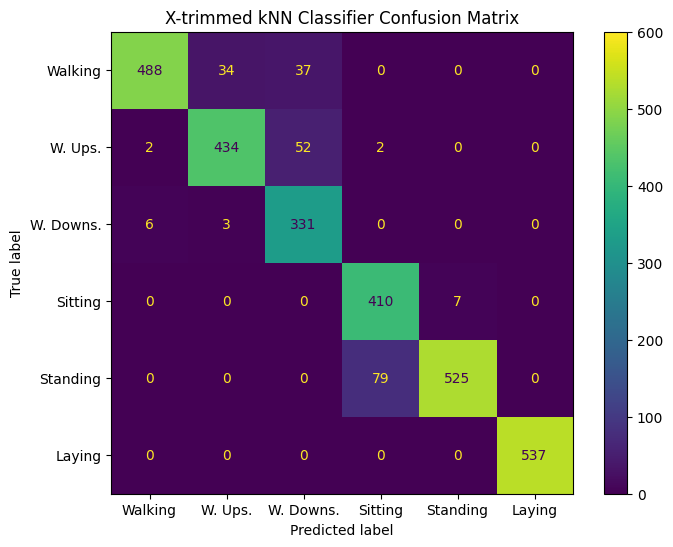

In [23]:
# Scaled kNN summary
X_test_trim = filtered_df(X_test_scaled, columns_keep)

model_summary(
    model = knn_opt2,
    X_test = X_test_trim,
    y_test=y_test,
    labels=labels,
    description="X-trimmed kNN Classifier",
    filename="A_kNN_Trimmed_CM.png"
)

O modelo de k-vizinhos mais próximos tem poucos parâmetros para ajuste. Foi possível melhorar os resultados com relação a otimizar apenas o número de vizinhos, mas o incremento foi relativamente pequeno. Os resultados com os dados de teste geralmente seguiram os incrementos nos resultados com a validação cruzada, mas nem em todos os testes. Em todas as tentativas os resultados ficaram abaixo daqueles do classificador logístico. 

## Raw Dataset

In [24]:
# Read raw data
folder = r"..\Lista02\UCI_HAR_Dataset\train\Inertial Signals"
signals = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
]

folder = r"..\Lista02\UCI_HAR_Dataset\train\Inertial Signals"
X_raw = read_csv_(f"{folder}\\{signals[0]}_train.txt")
for s in signals[1:]:
    X_raw_new = read_csv_(f"{folder}\\{s}_train.txt")
    X_raw = pd.concat([X_raw, X_raw_new], axis=1)
X_raw = X_raw.set_axis(range(len(X_raw.columns)), axis=1)

folder = r"..\Lista02\UCI_HAR_Dataset\test\Inertial Signals"
X_raw_test = read_csv_(f"{folder}\\{signals[0]}_test.txt")
for s in signals[1:]:
    X_raw_test_new = read_csv_(f"{folder}\\{s}_test.txt")
    X_raw_test = pd.concat([X_raw_test, X_raw_test_new], axis=1)
X_raw_test = X_raw_test.set_axis(range(len(X_raw_test.columns)), axis=1)

print("Train data")
print(f"  X: {X_raw.shape}")
print(f"  y: {y.shape}")
print("Test data")
print(f"  X: {X_raw_test.shape}")
print(f"  y: {y_test.shape}")

Train data
  X: (7352, 768)
  y: (7352, 1)
Test data
  X: (2947, 768)
  y: (2947, 1)


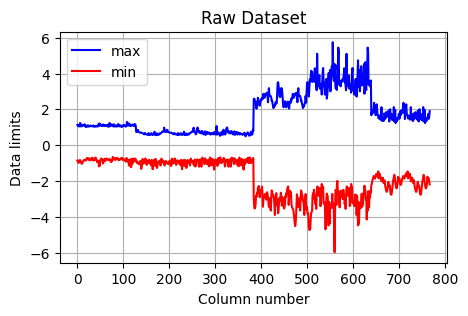

In [25]:
# Check raw data
plt.figure(figsize=(5, 3))
plt.plot(X_raw.max(), color="blue",label="max")
plt.plot(X_raw.min(), color="red",label="min")

plt.xlabel("Column number")
plt.ylabel("Data limits")
plt.title("Raw Dataset")
plt.grid(True)
plt.legend(loc="upper left")
plt.savefig(r"report/png/B_Dataset_Scale", bbox_inches="tight")
plt.show()

Os dados não estão normalizados. Os dados pré-processados estavam em [-1;1] e foi pequeno o efeito de mudar a escala para [0;1]. Os dados brutos serão escalados para [-1;1].

In [26]:
# Build features scaled [-1;1]
scaler_raw = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler_raw.fit_transform(X_raw)
X_raw_scaled = pd.DataFrame(scaled_data, columns=X_raw.columns)

scaled_data = scaler_raw.transform(X_raw_test)
X_raw_scaled_test = pd.DataFrame(scaled_data, columns=X_raw_test.columns)

### Logistic Regression

In [27]:
# Build logistic model
if RERUN:
    logistic_raw = LogisticRegressionCV(
        cv=5, solver="saga", scoring="balanced_accuracy", random_state=42, n_jobs=-1
    )
    logistic_raw.fit(X_raw_scaled, y[0].values)
    _ = joblib.dump(logistic_raw, "logistic_raw_model.sav")
else:
    logistic_raw = joblib.load("logistic_raw_model.sav")

print(f"Normalization coefficients l2:\n {[np.round(1/c, 4) for c in logistic_raw.C_]}")

balanced_accuracy[("Logistic raw","CV")] = logistic_raw.score(X_raw_scaled, y[0].values)
print(f"Logistic CV balanced accuracy = {balanced_accuracy[('Logistic raw','CV')]:0.4f}")
y_pred = logistic_raw.predict(X_raw_scaled_test)
balanced_accuracy[("Logistic raw","Test")] = recall_score(y_test, y_pred, average="macro")


Normalization coefficients l2:
 [21.5443, 21.5443, 21.5443, 21.5443, 21.5443, 21.5443]
Logistic CV balanced accuracy = 0.3911


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.2999 | 0.2957   |
---------------------------------
| Walking   | 0.2560 | 0.3409   |
| W. Ups.   | 0.2527 | 0.3434   |
| W. Downs. | 0.2881 | 0.3523   |
| Sitting   | 0.0754 | 0.1054   |
| Standing  | 0.6015 | 0.3760   |
| Laying    | 0.3259 | 0.2564   |


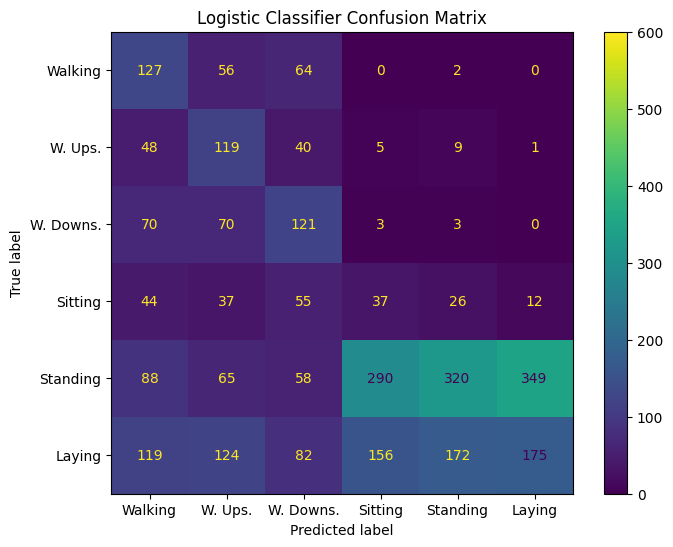

In [28]:
# Summarize logistic model
model_summary(
    model=logistic_raw,
    X_test=X_raw_scaled_test,
    y_test=y_test,
    labels=labels,
    description="Logistic Classifier",
    filename="B_Logistic_CM.png",
)

### kNN

Na primeira avaliação os ganhos com cálculos adicionais foram pequenos. Decidiu-se por construir apenas o classificador com os hiperparâmetros _padrão_.

In [29]:
# Build vanilla kNN
print("Vanilla kNN")

if RERUN:
    knn_raw_vanilla = KNeighborsClassifier()
    results = find_knn_best_k(
        X=X_raw_scaled,
        y=y,
        model=knn_raw_vanilla,
        k_range=range(1, 30),
        plot_filename="B_kNN_bestK.png",
        verbose=True,
    )
    knn_raw_vanilla, best_k_raw, balanced_accuracy[("kNN raw vanilla","CV")] = results

    _ = joblib.dump(knn_raw_vanilla, "knn_raw_vanilla_model.sav")
else:
    knn_raw_vanilla = joblib.load("knn_raw_vanilla_model.sav")
    best_k_raw = knn_raw_vanilla.get_params()["n_neighbors"]
    print(f"Best k = {best_k_raw}")
    balanced_accuracy[("kNN raw vanilla","CV")] = do_CV(
        X=X_raw_scaled,
        y=y[0],
        model=knn_raw_vanilla,
        retrain_all=True)
    print(f"Balanced accuracy = {balanced_accuracy[('kNN raw vanilla','CV')]:0.4f}")

y_pred = knn_raw_vanilla.predict(X_raw_scaled_test)
balanced_accuracy[("kNN raw vanilla","Test")] = recall_score(y_test, y_pred, average="macro")

Vanilla kNN
Best k = 1


Balanced accuracy = 0.7424


| Class     | Recall | F1 score |
---------------------------------
| All       | 0.7191 | 0.7352   |
---------------------------------
| Walking   | 0.8427 | 0.8875   |
| W. Ups.   | 0.8450 | 0.9108   |
| W. Downs. | 0.6452 | 0.7844   |
| Sitting   | 0.7026 | 0.5862   |
| Standing  | 0.5846 | 0.5466   |
| Laying    | 0.6946 | 0.6959   |


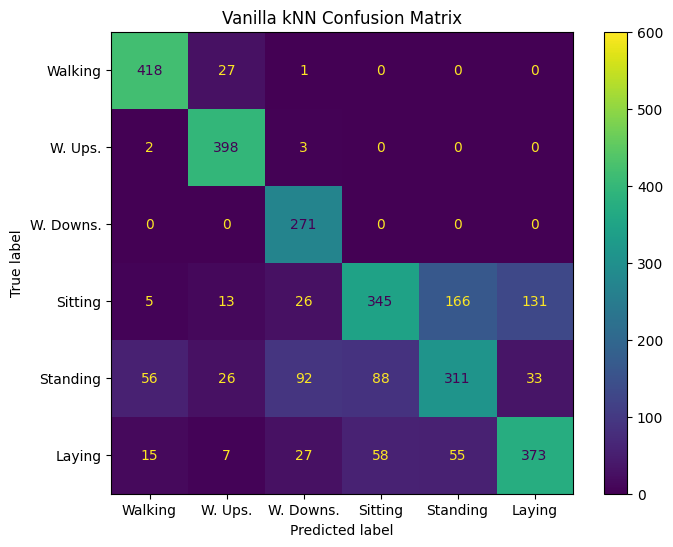

In [30]:
# Summarize Vanilla kNN
model_summary(
    model=knn_raw_vanilla,
    X_test=X_raw_scaled_test,
    y_test=y_test,
    labels=labels,
    description="Vanilla kNN",
    filename="B_kNN_Vanilla_CM",
)

Os resultados dos classificadores logístico e k-vizinhos mais próximos são significativamente piores quando treinados com os dados brutos. O classificador logístico foi o que mais teve dificuldades com os dados brutos. O classificador kNN _ótimo_ foi com apenas um vizinho (k=1), ou seja, é utilizada a classe do dado mais próximo.

## Results

In [31]:
# Print results table
results = [("Classifier","Type","Bal.Acc.")]
for k,v in balanced_accuracy.items():
    if k[1] == "CV":
        results.append(
            (k[0], k[1], f"{v:0.4f}")
        )
for k,v in balanced_accuracy.items():
    if k[1] == "Test":
        results.append(
            (k[0], k[1], f"{v:0.4f}")
        )
print_table(results, horizontal_lines=[1,8])

| Classifier      | Type | Bal.Acc. |
-------------------------------------
| Logistic        | CV   | 0.9932   |
| kNN vanilla     | CV   | 0.8999   |
| kNN opt1        | CV   | 0.9045   |
| kNN scaled      | CV   | 0.9059   |
| kNN trimmed     | CV   | 0.9218   |
| Logistic raw    | CV   | 0.3911   |
| kNN raw vanilla | CV   | 0.7424   |
-------------------------------------
| logistic        | Test | 0.9598   |
| kNN vanilla     | Test | 0.8999   |
| kNN opt1        | Test | 0.9146   |
| kNN scaled      | Test | 0.9153   |
| kNN trimmed     | Test | 0.9192   |
| Logistic raw    | Test | 0.2999   |
| kNN raw vanilla | Test | 0.7191   |


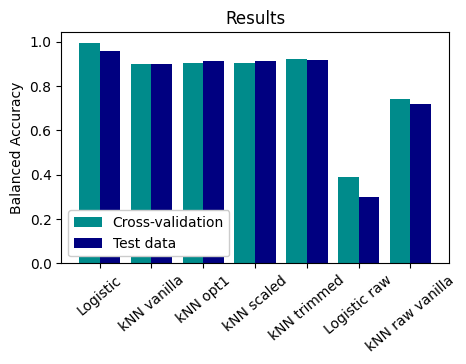

In [32]:
# Build results bar plot
results_labels = []
results_cv = []
results_test = []
for k,v in balanced_accuracy.items():
    if k[1] == "CV":
        results_labels.append(k[0])
        results_cv.append(v)
    else:
        results_test.append(v)

fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(
    np.arange(len(results_labels)) - 0.2,
    results_cv,
    color="darkcyan",
    width=0.4,
    align="center",
    label="Cross-validation"
)
ax.set_ylabel("Balanced Accuracy")

ax.bar(
    np.arange(len(results_labels)) + 0.2,
    results_test,
    color="navy",
    width=0.4,
    align="center",
    label="Test data"
)

plt.title("Results")
ax.set_xticks(np.arange(len(results_labels)))
ax.set_xticklabels(results_labels, rotation=40)
legend = plt.legend(loc="lower left")
frame = legend.get_frame()
frame.set_alpha(1)
plt.savefig("report/png/C_Results.png", bbox_inches="tight")
plt.show()

### Visualize data

In [33]:
# Plot scatter with principal components
def plot_reduced_data_subplots(data, filename, n_components=2, title=None):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    data_reduced = pca.transform(data)

    n_plots = int(n_components * (n_components-1) / 2)
    nrows = int((n_plots+1)/2)

    _, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(7, 3*nrows))
    i = 0
    j = 0
    for pc_a in range(n_components-1):
        for pc_b in range(pc_a+1,n_components):
            for n, label in enumerate(labels):
                axes[i,j].scatter(
                    data_reduced[y[0] == (n+1)][:, pc_a],
                    data_reduced[y[0] == (n+1)][:, pc_b],
                    s=6,
                    alpha=0.5,
                    label=label)
            axes[i,j].set_xlabel(f"PC {pc_a+1}")
            axes[i,j].set_ylabel(f"PC {pc_b+1}")
            axes[i,j].legend(loc="upper right", fontsize=6)
            j += 1
            if j == 2:
                j = 0
                i += 1

    plt.tight_layout()
    plt.savefig(f"report/png/{filename}", bbox_inches="tight")
    plt.show()

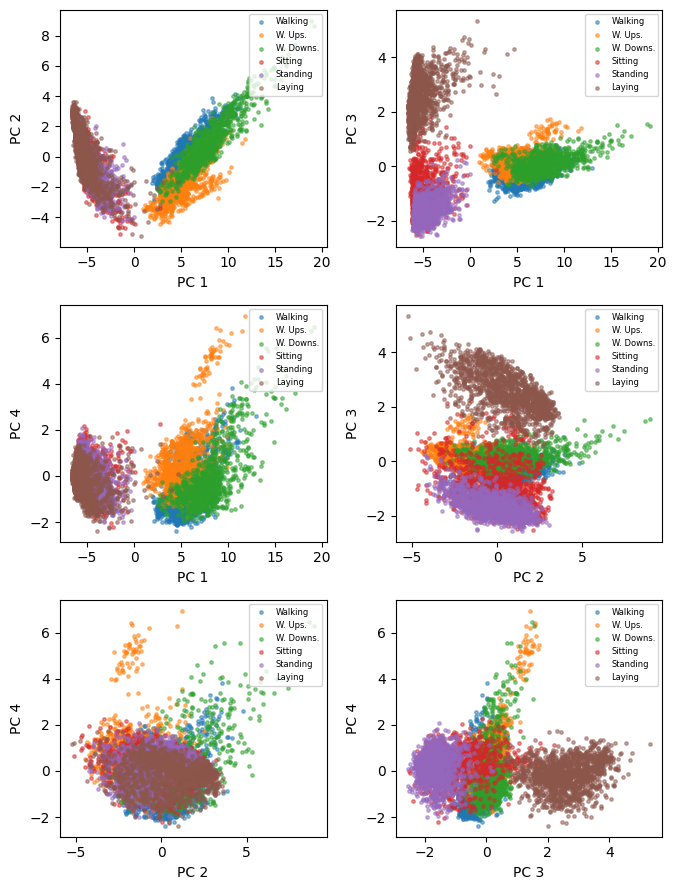

In [34]:
# X Reduced dimension
plot_reduced_data_subplots(X, "C_PrincipalComponents.png", 4)

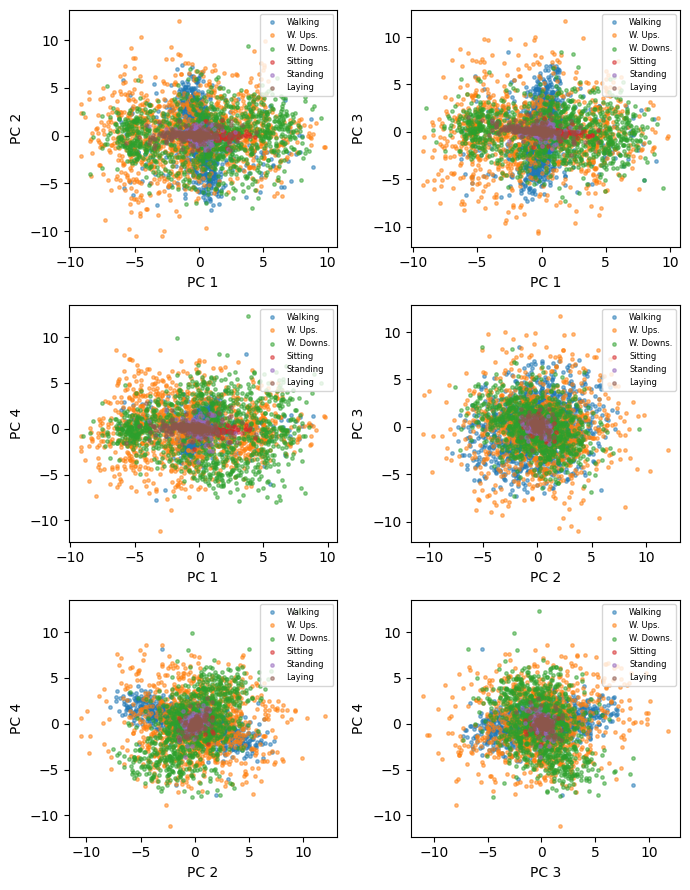

In [35]:
# X raw Reduced dimension
plot_reduced_data_subplots(X_raw, "C_PrincipalComponents_Raw.png", 4)

A diferença entre os modelos treinados com os dados brutos e os treinados com os dados pré-processados fica mais evidente quando tentamos representar os dados em um número menor de dimensões. Foi utilizada uma análise de componentes principais dos dados de entrada para gerar os gráficos. Foram comparados os valores das quatro componentes principais mais importantes. Fica evidente que é possível separar as classes dos dos dados pré-processados com hiperplanos, que é o que o classificador logístico faz. A diferença entre o **K** _ótimo_ dos modelos kNN construídos mostra que este modelo também tem melhor performance quando os dados apresentam alguma forma de agrupamento no espaço das variáveis. Os resultados mostram que foi preciso realizar transformações não-lineares nos dados para que a sua classificação fosse possível com os algoritmos testados. 

In [36]:
# Plot scatter with t-SNE
def plot_reduced_data_t_sne(data, filename, title=None):
    pca = PCA(n_components=50)
    pca.fit(data)
    pca_data_reduced = pca.transform(data)

    tsne = TSNE(n_components=2, perplexity=50)
    data_reduced = tsne.fit_transform(pca_data_reduced)


    plt.figure(figsize=(5, 3))
    for n, label in enumerate(labels):
        plt.scatter(
            data_reduced[y[0] == (n+1)][:, 0],
            data_reduced[y[0] == (n+1)][:, 1],
            s=6,
            alpha=0.5,
            label=label)

    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    if title is not None:
        plt.title(title)
    plt.legend(loc="upper right", fontsize=6)
    plt.tight_layout()
    plt.savefig(f"report/png/{filename}", bbox_inches="tight")
    plt.show()

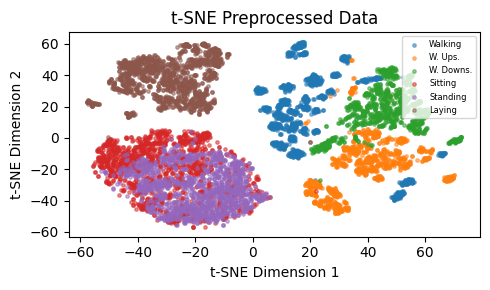

In [37]:
# t-SNE X Reduced dimension
plot_reduced_data_t_sne(X, "C_t-SNE.png", "t-SNE Preprocessed Data")

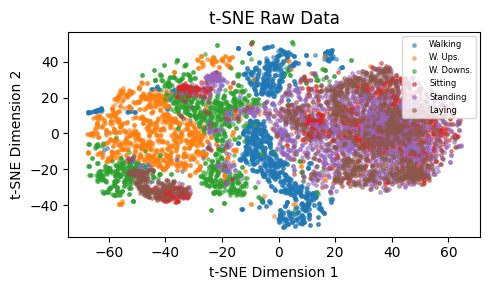

In [38]:
# t-SNE X raw Reduced dimension
plot_reduced_data_t_sne(X_raw, "C_t-SNE_raw.png", "t-SNE Raw Data")

In [96]:
# 3D Plot scatter with t-SNE
def plot_reduced_data_t_sne_3D(data, filename, title=None):
    pca = PCA(n_components=50)
    pca.fit(data)
    pca_data_reduced = pca.transform(data)

    tsne = TSNE(n_components=3, perplexity=50)
    data_reduced = tsne.fit_transform(pca_data_reduced)

    data = {'x': data_reduced[:, 0],
            'y': data_reduced[:, 1],
            'z': data_reduced[:, 2],
            'class': [get_label_name(x) for x in y[0]]}
    df = pd.DataFrame(data)
    fig = px.scatter_3d(df,
        x='x',
        y='y',
        z='z',
        color='class')
    if title is not None:
        fig.update_layout(title=title)
    fig.update_layout(showlegend=True)
    fig.update_traces(marker=dict(size=8, opacity=0.8))
    fig.write_html(f"report/html/{filename}", auto_open=True)

In [97]:
# t-SNE X Reduced dimension in 3D
plot_reduced_data_t_sne_3D(X, "C_t-SNE_3D.html", "t-SNE Preprocessed Data")

In [98]:
# t-SNE X raw Reduced dimension in 3D
plot_reduced_data_t_sne_3D(X_raw, "C_t-SNE_3D_raw.html", "t-SNE Raw Data")